In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split



In [18]:


# Define transformations for the test set
transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])



In [19]:
# Load the entire dataset
image_dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images"
full_dataset = datasets.ImageFolder(image_dir)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Create subsets for train and test
train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

# Apply transformations to train and test subsets
train_subset.dataset.transform = transforms
test_subset.dataset.transform = transforms

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

# Check the number of images in train and test sets
print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22046

Number of images in test set: 5512


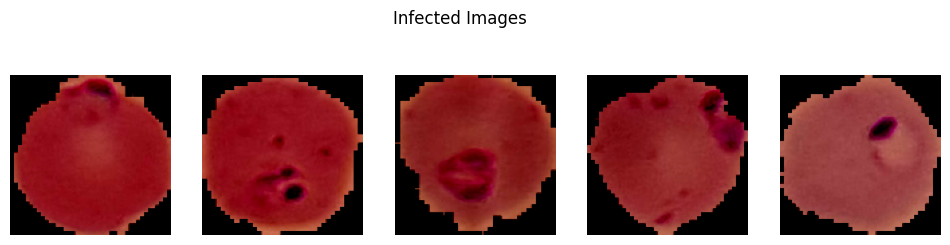

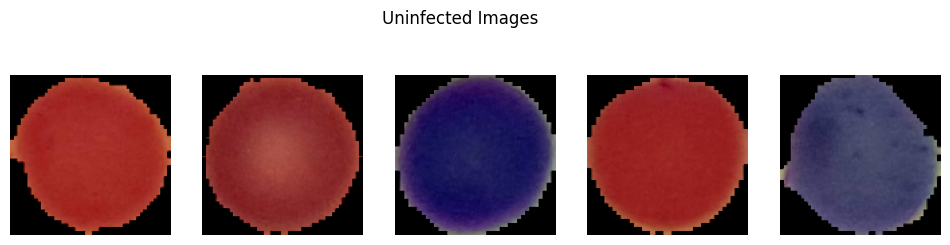

In [20]:
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Define classes
classes = ['infected', 'uninfected']

# Function to get a batch of images from the loader
def get_batch(loader, class_index, num_images):
    for batch, labels in loader:
        images = batch[labels == class_index][:num_images]
        return images

# Get five images of infected class
infected_images = get_batch(train_loader, class_index=0, num_images=5)
show_images(infected_images, 'Infected Images')

# Get five images of uninfected class
uninfected_images = get_batch(train_loader, class_index=1, num_images=5)
show_images(uninfected_images, 'Uninfected Images')

In [21]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

In [40]:

input_size = 120 * 120 * 3
num_classes = 2
num_epochs = 30
best_test_accuracy = 0.0
early_stopping_patience = 6
early_stopping_counter = 0

# Initialize the model
model = LogisticRegressionModel(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = StepLR(optimizer,step_size=3, gamma=0.5)

# Training the model


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.view(-1, input_size)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy, test_accuracy))

    scheduler.step()

    # Early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping at epoch', epoch+1)
            break

print('Finished Training')

# Evaluation using scikit-learn metrics
model.eval()
true_labels = []
predicted_probabilities = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, input_size)
        outputs = model(images)
        predicted_probabilities.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

predicted_labels = np.argmax(predicted_probabilities, axis=1)

Epoch [1/30], Train Loss: 0.6180, Train Accuracy: 66.40%, Test Accuracy: 67.49%

Epoch [2/30], Train Loss: 0.6020, Train Accuracy: 68.24%, Test Accuracy: 66.89%

Epoch [3/30], Train Loss: 0.5968, Train Accuracy: 68.57%, Test Accuracy: 68.69%

Epoch [4/30], Train Loss: 0.5885, Train Accuracy: 69.20%, Test Accuracy: 68.27%

Epoch [5/30], Train Loss: 0.5862, Train Accuracy: 69.28%, Test Accuracy: 69.05%

Epoch [6/30], Train Loss: 0.5842, Train Accuracy: 69.52%, Test Accuracy: 69.47%

Epoch [7/30], Train Loss: 0.5791, Train Accuracy: 70.21%, Test Accuracy: 68.34%

Epoch [8/30], Train Loss: 0.5787, Train Accuracy: 70.13%, Test Accuracy: 68.36%

Epoch [9/30], Train Loss: 0.5770, Train Accuracy: 70.29%, Test Accuracy: 69.23%

Epoch [10/30], Train Loss: 0.5747, Train Accuracy: 70.67%, Test Accuracy: 69.21%

Epoch [11/30], Train Loss: 0.5746, Train Accuracy: 70.58%, Test Accuracy: 69.18%

Epoch [12/30], Train Loss: 0.5739, Train Accuracy: 70.67%, Test Accuracy: 69.29%

Early stopping at epoch 1

In [41]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.6928519593613933


In [42]:
print('Classification Report:')
print(classification_report(true_labels, predicted_labels))

Classification Report:

              precision    recall  f1-score   support



           0       0.69      0.72      0.70      2797

           1       0.70      0.66      0.68      2715



    accuracy                           0.69      5512

   macro avg       0.69      0.69      0.69      5512

weighted avg       0.69      0.69      0.69      5512




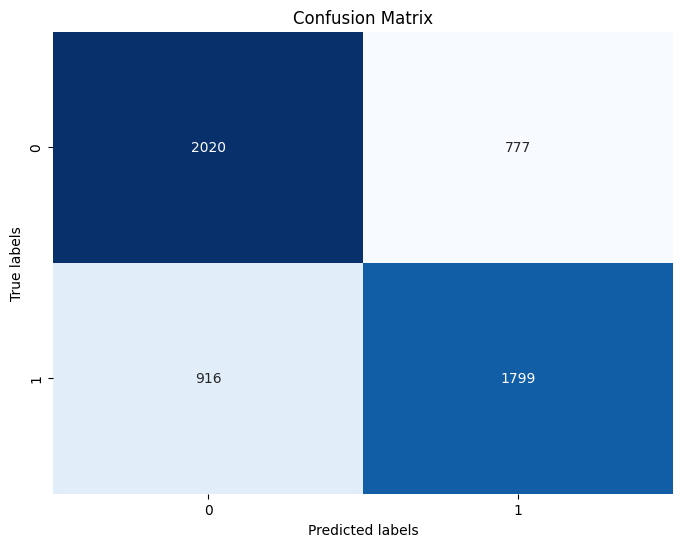

In [43]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()